# Spectral Unmixing Notebook
## Adapted from Ochoa et al. (2025) for SVC data
Follow installation instructions step in README.md (https://github.com/emit-sds/SpectralUnmixing.jl) prior to running. 

Script only includes endmember and nadir spectra from plots 1108, 1310 and 1405 (as these are the only plots we have both leaf and nadir measurements for). 

In [1]:
using Pkg
Pkg.activate("C:/Users/zhalem/Documents/spectralunmixing")  
Pkg.instantiate()

  Activating project at `C:\Users\zhalem\Documents\spectralunmixing`


In [2]:
using Plots
using SpectralUnmixing
using Statistics
using CSV
using DataFrames
using Pkg
Pkg.instantiate()    # installs any missing dependencies recorded for this environment
Pkg.add("Plots")     # explicitly adds Plots if it’s not in the Project.toml
Pkg.add("Statistics")  

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\zhalem\Documents\spectralunmixing\Project.toml`
    Manifest No packages added to or removed from `C:\Users\zhalem\Documents\spectralunmixing\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\zhalem\Documents\spectralunmixing\Project.toml`
    Manifest No packages added to or removed from `C:\Users\zhalem\Documents\spectralunmixing\Manifest.toml`


# Spectral Library Preparation

Start by loading up a spectral library (Ochoa et al. [10.21232/QijXnpFt](https://doi.org/10.21232/QijXnpFt)), filtering it down to the desired classes, interpolating the spectra to the relevant wavelengths, and then removing undesired wavelength regions. By default the ignored regions correspond to atmospheric absorption regions. Here we split the library into two classes, soil and vegetation.

In [3]:
open("fake_refle.hdr", "w") do io
    wavelengths = 360:2500
    println(io, "ENVI")
    println(io, "description = {Fake SVC header for unmixing}")
    println(io, "samples = 1")
    println(io, "lines = 1")
    println(io, "bands = $(length(wavelengths))")
    println(io, "data type = 4")
    println(io, "interleave = bsq")
    println(io, "byte order = 0")
    println(io, "wavelength units = Nanometers")
    println(io, "wavelength = {" * join(wavelengths, ", ") * "}")
end

[ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]


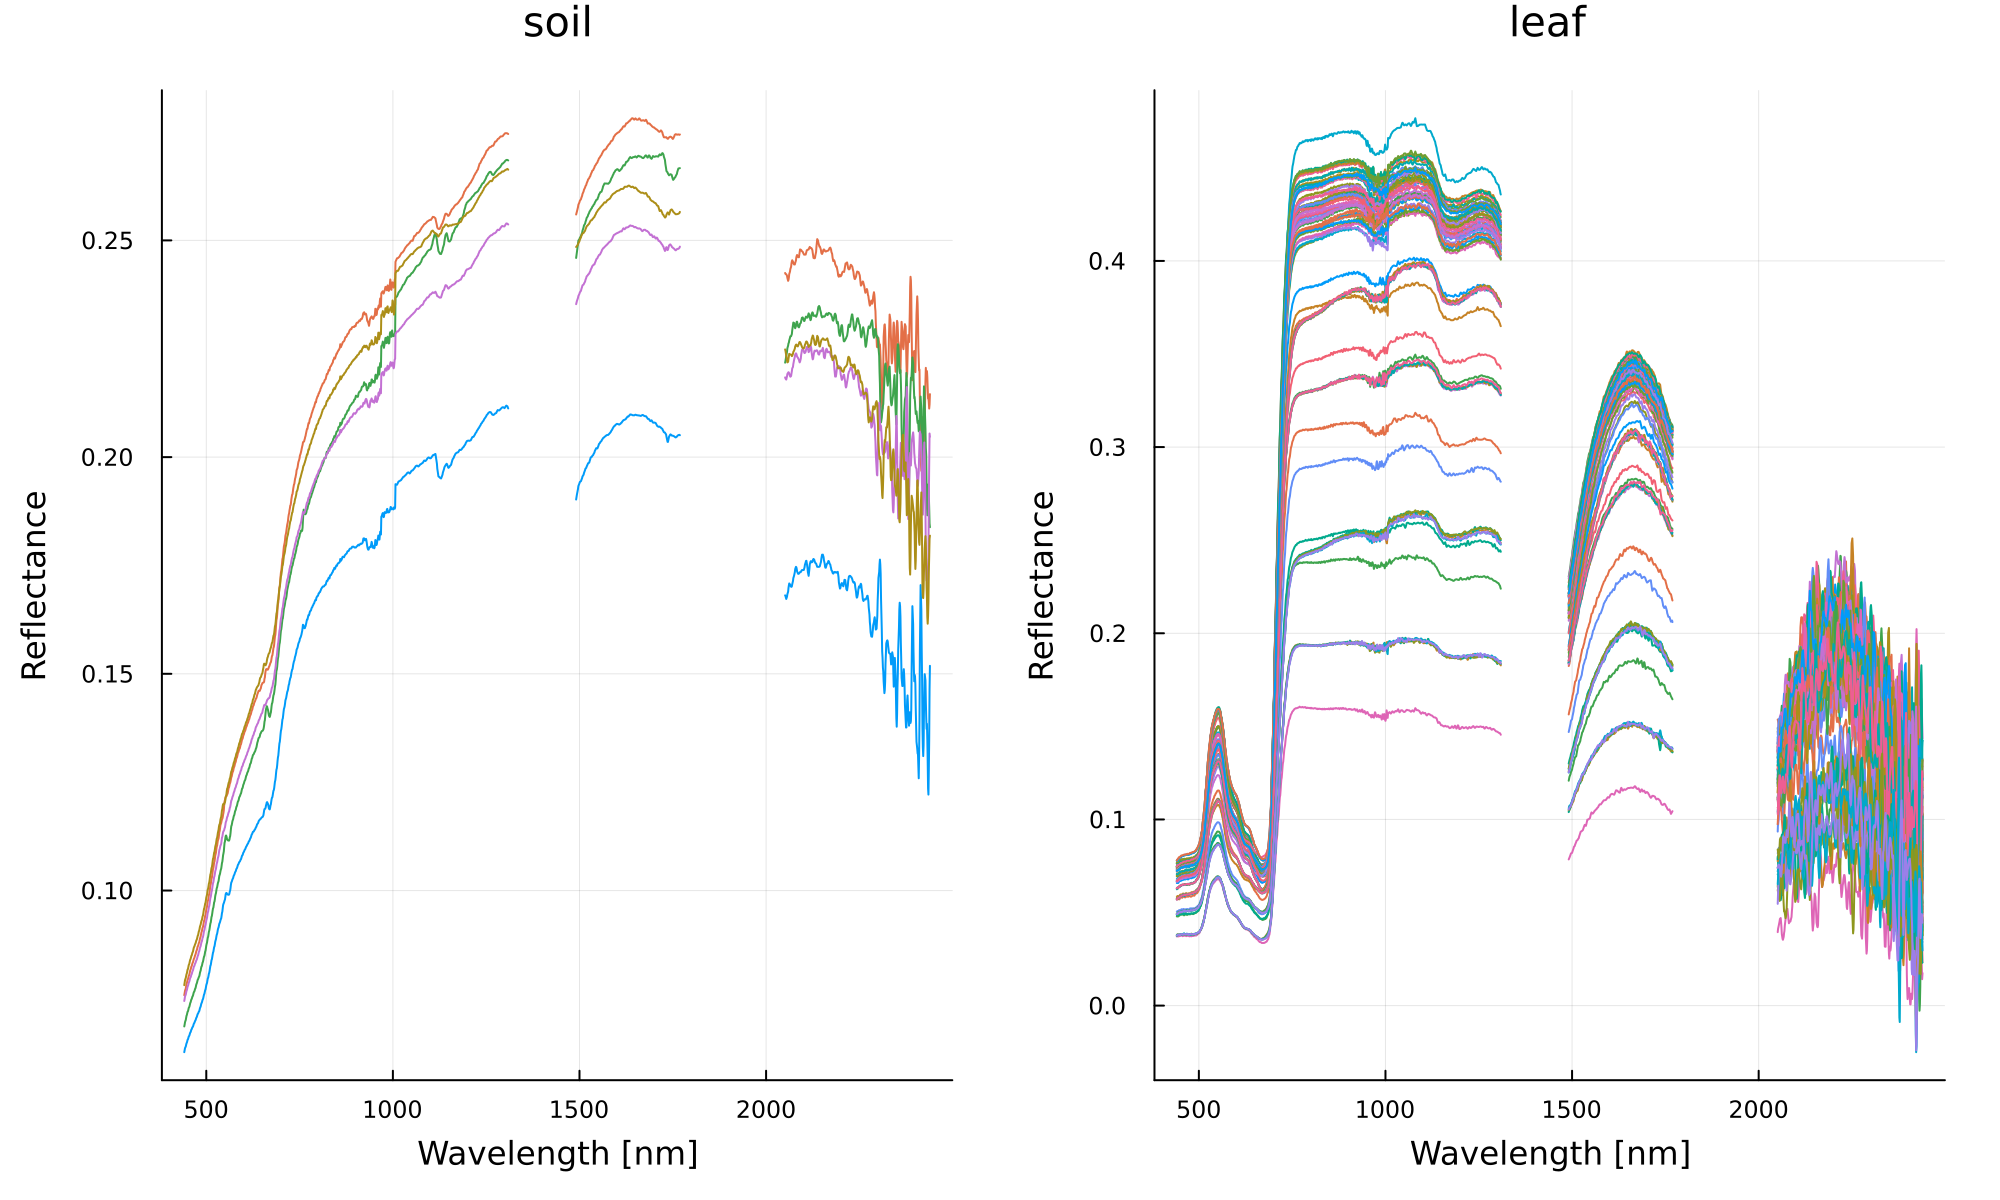

In [4]:
# two endmember classes (column name 'level_1') are soil and leaf
endmember_library = SpectralLibrary("endmember_svc_data_pangeos_limited.csv", "level_1", 10, 0, ["soil","leaf"]);
load_data!(endmember_library);
filter_by_class!(endmember_library);

# 10, 0 refers to number of spectral bands to skip between samples or a window size for smoothing
# make sure the 'fake_refle' file is downloaded in the correct folder prior to running
# 'fake_refle' is an envi format file with all wavelengths

refl_file_wl = read_envi_wavelengths("fake_refle");
interpolate_library_to_new_wavelengths!(endmember_library, refl_file_wl);

# remove water band regions with lots of noise
# fill the ignored regions with NaNs to improve visualization of the endmember spectra.
remove_wavelength_region_inplace!(endmember_library, true);

plot_endmembers_individually(endmember_library)
plot!(margin=5Plots.mm)

In [5]:
# Copies the library spectra and wavelengths so we don't modify the original directly
# Clean the library wavelength axis (remove NaNs, duplicates, sorts) 
lib_wl = copy(endmember_library.wavelengths)
lib_spec = copy(endmember_library.spectra)

# Remove NaNs in wavelengths
valid_idx = findall(!isnan, lib_wl)
lib_wl = lib_wl[valid_idx]
lib_spec = lib_spec[:, valid_idx]

# update the library
endmember_library.wavelengths = lib_wl
endmember_library.spectra = lib_spec;

In [6]:
# Loads in measured spectra (mixed spectra)
mixed_file = "mixed_rows_test_limited.csv"
df_mixed = CSV.read(mixed_file, DataFrame)

# Extract spectrum names (first column = fname)
mixed_names = df_mixed.fname

# Extract reflectances (remaining columns), keep NaNs for masked bands
mixed_rfl = Matrix{Float64}(coalesce.(df_mixed[:, Not(:fname)], NaN));

In [7]:
# Attempt to infer measurement wavelength axis from column names when appropriate:
#retrieve column headers
col_names = names(df_mixed)
first_col_is_name = eltype(df_mixed[:,1]) <: AbstractString

# if statement to check that the strings in columns 2:end are purely numbers, not letters
# r"..." = Julia regular expression (regex)
# ^ = start of string
# \d+ = one or more digits (0-9)
# $ = end of string
if first_col_is_name && all(x -> occursin(r"^\d+$", x), string.(col_names[2:end]))
    my_wavelengths = Float64.(parse.(Float64, string.(col_names[2:end])))
else
    # Fallback: assume 360..2500 step 1 
    my_wavelengths = Float64.(360:1:2500)
end

# sanity checks to make sure matrix size and wavelengths match
@show size(mixed_rfl)
@show length(my_wavelengths)

size(mixed_rfl) = (25, 2141)
length(my_wavelengths) = 2141


2141

In [8]:
# 3) Interpolate / align endmember library to measurement wavelengths
interpolate_library_to_new_wavelengths!(endmember_library, my_wavelengths)

# Remove ignored/bad wavelength regions entirely (faster for computation)
# pass false to remove them instead of filling with NaNs
remove_wavelength_region_inplace!(endmember_library, true)

# Sanity checks to ensure lengths match
@show length(endmember_library.wavelengths)
@show sum(endmember_library.good_bands)
@show size(endmember_library.spectra)

length(endmember_library.wavelengths) = 2141
sum(endmember_library.good_bands) = 1537
size(endmember_library.spectra) = (81, 2141)


(81, 2141)

# A Single SMA Unmixing Case
Unmixing is done using a Monte Carlo (MC) method where endmembers are chosen at random to construct the unmixing matrices using two main approaches: spectral mixture analysis (SMA) and multiple-endmember spectral mixture analysis (MESMA).

There are a few options that must be set for unmixing, including the number of MC loops, the unmixing mode (`"sma-best"` here corresponds to SMA and using the lowest cost solution from MC), number of endmembers, the normalization mode, and optimization mode. After the prep steps, the single function `unmix_pixel()` performs the MC matrix inversions and outputs the unmixing results.

See Ochoa et al. (in preparation) for more info on different unmixing techniques and options.

In [9]:
#4) Prepare options and combination indices for unmixing
n_mc = 25
mode = "sma-best" 
num_endmembers = [30]          # vector expected by prepare_options
normalization = "none"   # normalization = 'none' for no brightness normalization (or "brightness" if you want to normalize by brightness, but does not make sense in this case because there is no canopy shading like with satellite data)
optimization = "bvls"
max_combinations = 1000
combination_type = "class-even"

"class-even"

In [10]:
# Prepare combination/class indices and options (these helper functions are from SpectralUnmixing)
class_idx = prepare_combinations(endmember_library, combination_type)
options = prepare_options(endmember_library, combination_type, num_endmembers, class_idx)

# Prepare storage for CSV export
spectrum_name_out = String[]
brightness_out    = Float64[]
soil_frac_out     = Float64[]
leaf_frac_out     = Float64[]

# 5) Unmix each measured spectrum using the prepared library
println("Starting unmixing for $(size(mixed_rfl,1)) spectra...")

n_spectra = size(mixed_rfl,1)
cfr_all = Vector{Any}(undef, n_spectra)  # store cfr for each spectrum
mr_all  = Vector{Vector{Float64}}(undef, n_spectra)
mv_all  = Vector{Vector{Float64}}(undef, n_spectra)
cfv_all = Vector{Vector{Float64}}(undef, n_spectra)

for i in 1:size(mixed_rfl,1)
    # Mask measured spectrum to only the library 'good' bands
    # If library.good_bands is boolean mask, use it directly; otherwise assume it is indices
    gb = endmember_library.good_bands
    good_mask = endmember_library.good_bands
    spectrum_vec = vec(mixed_rfl[i, good_mask])

    # Run unmixing
    mr, mv, cfr, cfv = unmix_pixel(
        endmember_library,
        spectrum_vec,
        nothing,          # no ancillary (e.g. mask) provided
        class_idx,
        options,
        mode,
        n_mc,
        num_endmembers,
        normalization,
        optimization,
        max_combinations,
        combination_type
    )

    #store cfr for this spectrum
    cfr_all[i] = cfr
# Output: brightness appended as last element in mr
    brightness = mr[end]
    println("Spectrum $(mixed_names[i]): Brightness: $(round(brightness*100, digits=2)) %")
    for (class, fraction) in zip(endmember_library.class_valid_keys, mr[1:end-1])
        println("    $class fraction: $(round(fraction*100, digits=2)) %")     
    end

    push!(spectrum_name_out, mixed_names[i])
    push!(brightness_out, brightness)

    fractions = Dict(
        class => frac for (class, frac) in
        zip(endmember_library.class_valid_keys, mr[1:end-1])
    )

    push!(soil_frac_out, fractions["soil"])
    push!(leaf_frac_out, fractions["leaf"])

end

results_df = DataFrame(
    spectrum_name = spectrum_name_out,
    brightness    = brightness_out,
    soil_fraction = soil_frac_out,
    leaf_fraction = leaf_frac_out
)

CSV.write("unmixing_results_limited.csv", results_df)

Starting unmixing for 25 spectra...
Spectrum 14deg_plot_11_08_0000 (2): Brightness: 48.99 %
    soil fraction: 0.0 %
    leaf fraction: 100.0 %
Spectrum 14deg_plot_11_08_0000: Brightness: 64.03 %
    soil fraction: 22.62 %
    leaf fraction: 77.38 %
Spectrum 14deg_plot_11_08_0001 (2): Brightness: 49.04 %
    soil fraction: 0.0 %
    leaf fraction: 100.0 %
Spectrum 14deg_plot_11_08_0001: Brightness: 71.67 %
    soil fraction: 15.76 %
    leaf fraction: 84.24 %
Spectrum 14deg_plot_11_08_0002 (2): Brightness: 49.87 %
    soil fraction: 0.0 %
    leaf fraction: 100.0 %
Spectrum 14deg_plot_11_08_0002: Brightness: 65.83 %
    soil fraction: 23.32 %
    leaf fraction: 76.68 %
Spectrum 14deg_plot_11_08_0003 (2): Brightness: 50.14 %
    soil fraction: 0.0 %
    leaf fraction: 100.0 %
Spectrum 14deg_plot_11_08_0003: Brightness: 61.0 %
    soil fraction: 10.04 %
    leaf fraction: 89.96 %
Spectrum 14deg_plot_11_08_0004 (2): Brightness: 44.29 %
    soil fraction: 0.0 %
    leaf fraction: 100.0 %
S

"unmixing_results_limited.csv"